## **0. Import libraries**

In [1]:
import torch
import random
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

c:\Users\ACER\miniconda3\Lib\site-packages\torch\cuda\__init__.py:182: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10\cuda\CUDAFunctions.cpp:119.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

## **1. Prepare dataset**


In [3]:
batch_size = 512

train_dataset = FashionMNIST('./data',
                             train=True,
                             download=True,
                             transform=transforms.ToTensor())
test_dataset = FashionMNIST('./data',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())

train_ratio = 0.9
train_size = int(len(train_dataset) * train_ratio)
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_subset)}")
print(f"Validation size: {len(val_subset)}")
print(f"Test size: {len(test_dataset)}")


Train size: 54000
Validation size: 6000
Test size: 10000


## **2. Build MLP network**




In [4]:
class MLP_1layer(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(MLP_1layer, self).__init__()
        self.layer1 = nn.Linear(input_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        return x


class MLP_2layers(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(MLP_2layers, self).__init__()
        self.layer1 = nn.Linear(input_dims, output_dims)
        self.layer2 = nn.Linear(output_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        return x

In [5]:
first = MLP_2layers(input_dims=784, output_dims=128)
second = MLP_2layers(input_dims=128, output_dims=128)
third = MLP_2layers(input_dims=128, output_dims=128)
fourth = MLP_1layer(input_dims=128, output_dims=128)

lr = 1e-2
criterion = nn.CrossEntropyLoss()

## **3. Training 1**

In [6]:
model = nn.Sequential(
    first,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

In [7]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(test_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 2.3077, Train_Acc: 0.1206, Validation Loss: 1.3809, Val_Acc: 0.1167
EPOCH 2/100, Train_Loss: 2.3001, Train_Acc: 0.1249, Validation Loss: 1.3793, Val_Acc: 0.1375
EPOCH 3/100, Train_Loss: 2.2973, Train_Acc: 0.1711, Validation Loss: 1.3777, Val_Acc: 0.1715
EPOCH 4/100, Train_Loss: 2.2945, Train_Acc: 0.2014, Validation Loss: 1.3760, Val_Acc: 0.1405
EPOCH 5/100, Train_Loss: 2.2915, Train_Acc: 0.2186, Validation Loss: 1.3739, Val_Acc: 0.2873
EPOCH 6/100, Train_Loss: 2.2884, Train_Acc: 0.2754, Validation Loss: 1.3722, Val_Acc: 0.2692
EPOCH 7/100, Train_Loss: 2.2850, Train_Acc: 0.2711, Validation Loss: 1.3698, Val_Acc: 0.4283
EPOCH 8/100, Train_Loss: 2.2813, Train_Acc: 0.3501, Validation Loss: 1.3680, Val_Acc: 0.2873
EPOCH 9/100, Train_Loss: 2.2774, Train_Acc: 0.3453, Validation Loss: 1.3652, Val_Acc: 0.4052
EPOCH 10/100, Train_Loss: 2.2730, Train_Acc: 0.3496, Validation Loss: 1.3624, Val_Acc: 0.3010
EPOCH 11/100, Train_Loss: 2.2680, Train_Acc: 0.3796, Validation Loss:

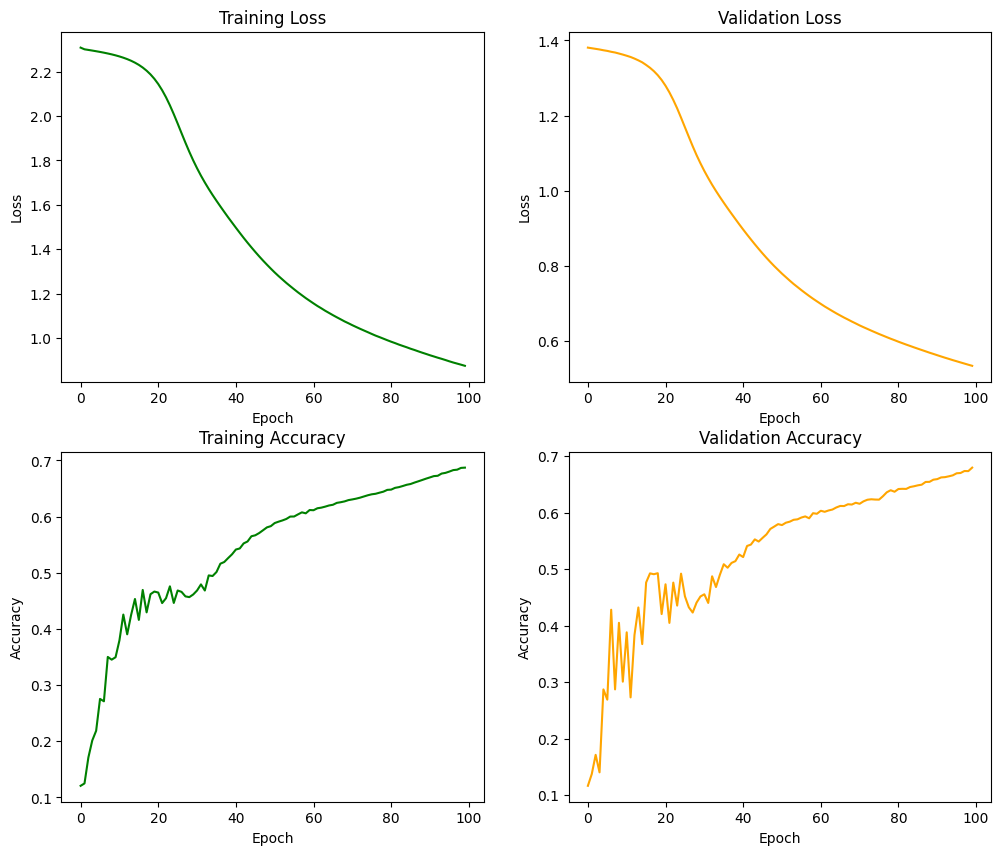

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## **4. Training 2**

In [9]:
for param in first.parameters():
    param.requires_grad = False

model = nn.Sequential(
    first,
    second,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

In [10]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(test_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 2.3049, Train_Acc: 0.0988, Validation Loss: 1.3816, Val_Acc: 0.1020
EPOCH 2/100, Train_Loss: 2.3022, Train_Acc: 0.1090, Validation Loss: 1.3813, Val_Acc: 0.0937
EPOCH 3/100, Train_Loss: 2.3017, Train_Acc: 0.1090, Validation Loss: 1.3811, Val_Acc: 0.0997
EPOCH 4/100, Train_Loss: 2.3012, Train_Acc: 0.1179, Validation Loss: 1.3805, Val_Acc: 0.1020
EPOCH 5/100, Train_Loss: 2.3007, Train_Acc: 0.1252, Validation Loss: 1.3805, Val_Acc: 0.0895
EPOCH 6/100, Train_Loss: 2.3002, Train_Acc: 0.1244, Validation Loss: 1.3800, Val_Acc: 0.1018
EPOCH 7/100, Train_Loss: 2.2996, Train_Acc: 0.1324, Validation Loss: 1.3797, Val_Acc: 0.1000
EPOCH 8/100, Train_Loss: 2.2990, Train_Acc: 0.1246, Validation Loss: 1.3795, Val_Acc: 0.0895
EPOCH 9/100, Train_Loss: 2.2985, Train_Acc: 0.1779, Validation Loss: 1.3794, Val_Acc: 0.2447
EPOCH 10/100, Train_Loss: 2.2980, Train_Acc: 0.1576, Validation Loss: 1.3786, Val_Acc: 0.2010
EPOCH 11/100, Train_Loss: 2.2973, Train_Acc: 0.1790, Validation Loss:

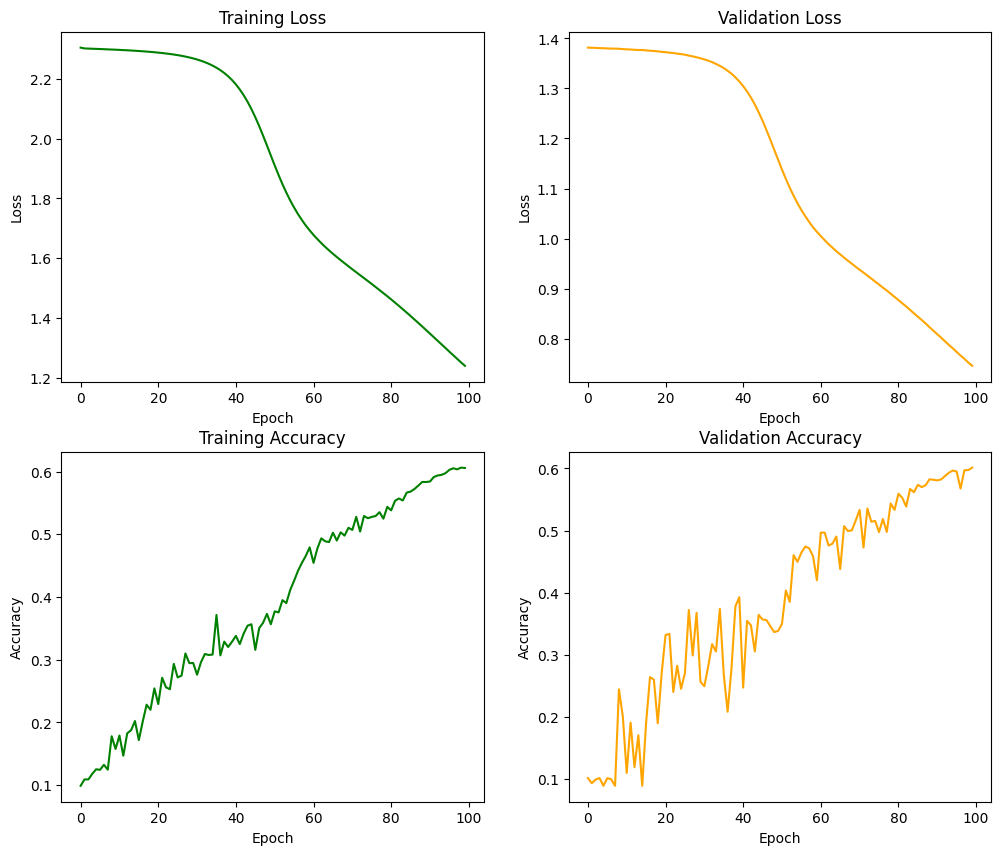

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## **5. Training 3**

In [12]:
for param in first.parameters():
    param.requires_grad = False
for param in second.parameters():
    param.requires_grad = False

model = nn.Sequential(
    first,
    second,
    third,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

In [13]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(test_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 2.3032, Train_Acc: 0.1021, Validation Loss: 1.3816, Val_Acc: 0.0895
EPOCH 2/100, Train_Loss: 2.3023, Train_Acc: 0.0986, Validation Loss: 1.3811, Val_Acc: 0.1012
EPOCH 3/100, Train_Loss: 2.3018, Train_Acc: 0.1072, Validation Loss: 1.3812, Val_Acc: 0.0895
EPOCH 4/100, Train_Loss: 2.3013, Train_Acc: 0.1089, Validation Loss: 1.3808, Val_Acc: 0.1023
EPOCH 5/100, Train_Loss: 2.3009, Train_Acc: 0.1083, Validation Loss: 1.3803, Val_Acc: 0.1003
EPOCH 6/100, Train_Loss: 2.3003, Train_Acc: 0.1285, Validation Loss: 1.3802, Val_Acc: 0.1913
EPOCH 7/100, Train_Loss: 2.2999, Train_Acc: 0.1313, Validation Loss: 1.3798, Val_Acc: 0.2153
EPOCH 8/100, Train_Loss: 2.2994, Train_Acc: 0.1311, Validation Loss: 1.3797, Val_Acc: 0.1003
EPOCH 9/100, Train_Loss: 2.2988, Train_Acc: 0.1375, Validation Loss: 1.3795, Val_Acc: 0.0980
EPOCH 10/100, Train_Loss: 2.2982, Train_Acc: 0.1266, Validation Loss: 1.3789, Val_Acc: 0.1872
EPOCH 11/100, Train_Loss: 2.2976, Train_Acc: 0.1550, Validation Loss:

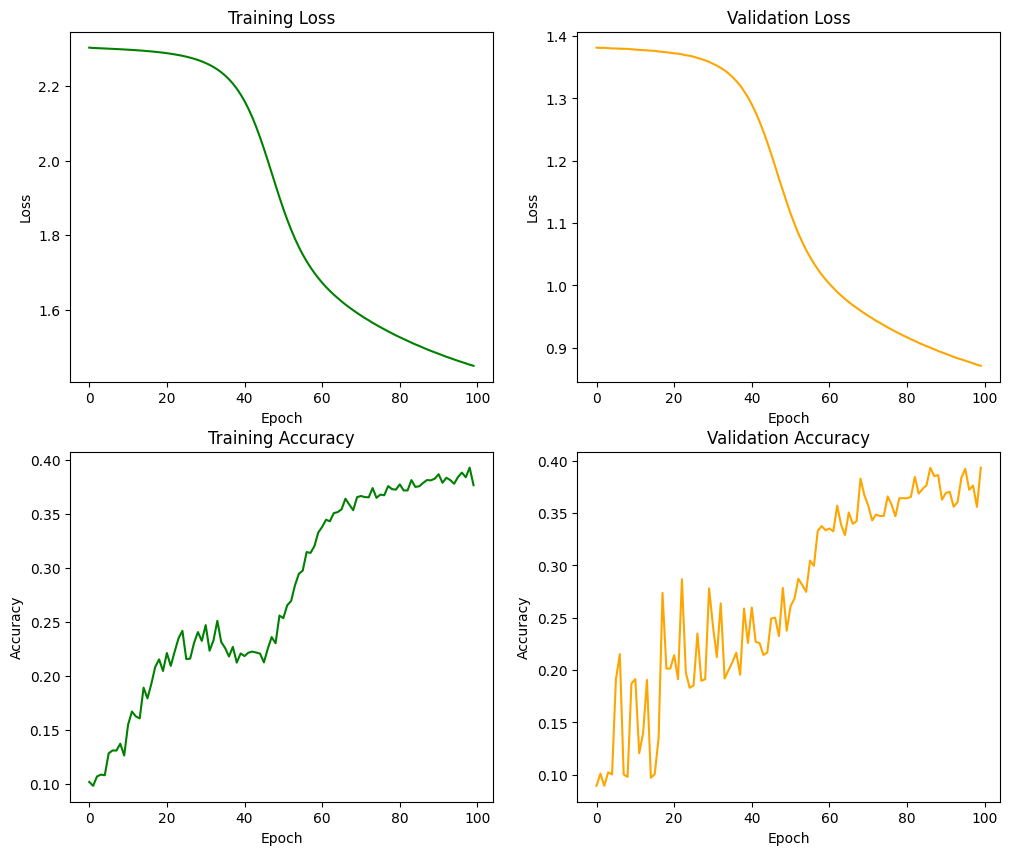

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## **6. Training 4**


In [15]:
for param in first.parameters():
    param.requires_grad = True
for param in second.parameters():
    param.requires_grad = True

model = nn.Sequential(
    first,
    second,
    third,
    nn.Linear(128, 10)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [16]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(test_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 2.1492, Train_Acc: 0.2060, Validation Loss: 1.2143, Val_Acc: 0.2017
EPOCH 2/100, Train_Loss: 1.9443, Train_Acc: 0.2215, Validation Loss: 1.1307, Val_Acc: 0.2568
EPOCH 3/100, Train_Loss: 1.8388, Train_Acc: 0.2527, Validation Loss: 1.0838, Val_Acc: 0.2573
EPOCH 4/100, Train_Loss: 1.7767, Train_Acc: 0.2680, Validation Loss: 1.0551, Val_Acc: 0.2878
EPOCH 5/100, Train_Loss: 1.7365, Train_Acc: 0.2857, Validation Loss: 1.0353, Val_Acc: 0.3342
EPOCH 6/100, Train_Loss: 1.7084, Train_Acc: 0.3045, Validation Loss: 1.0207, Val_Acc: 0.3035
EPOCH 7/100, Train_Loss: 1.6865, Train_Acc: 0.3087, Validation Loss: 1.0092, Val_Acc: 0.3142
EPOCH 8/100, Train_Loss: 1.6687, Train_Acc: 0.3218, Validation Loss: 0.9996, Val_Acc: 0.3335
EPOCH 9/100, Train_Loss: 1.6533, Train_Acc: 0.3313, Validation Loss: 0.9906, Val_Acc: 0.3205
EPOCH 10/100, Train_Loss: 1.6392, Train_Acc: 0.3352, Validation Loss: 0.9824, Val_Acc: 0.3535
EPOCH 11/100, Train_Loss: 1.6257, Train_Acc: 0.3357, Validation Loss:

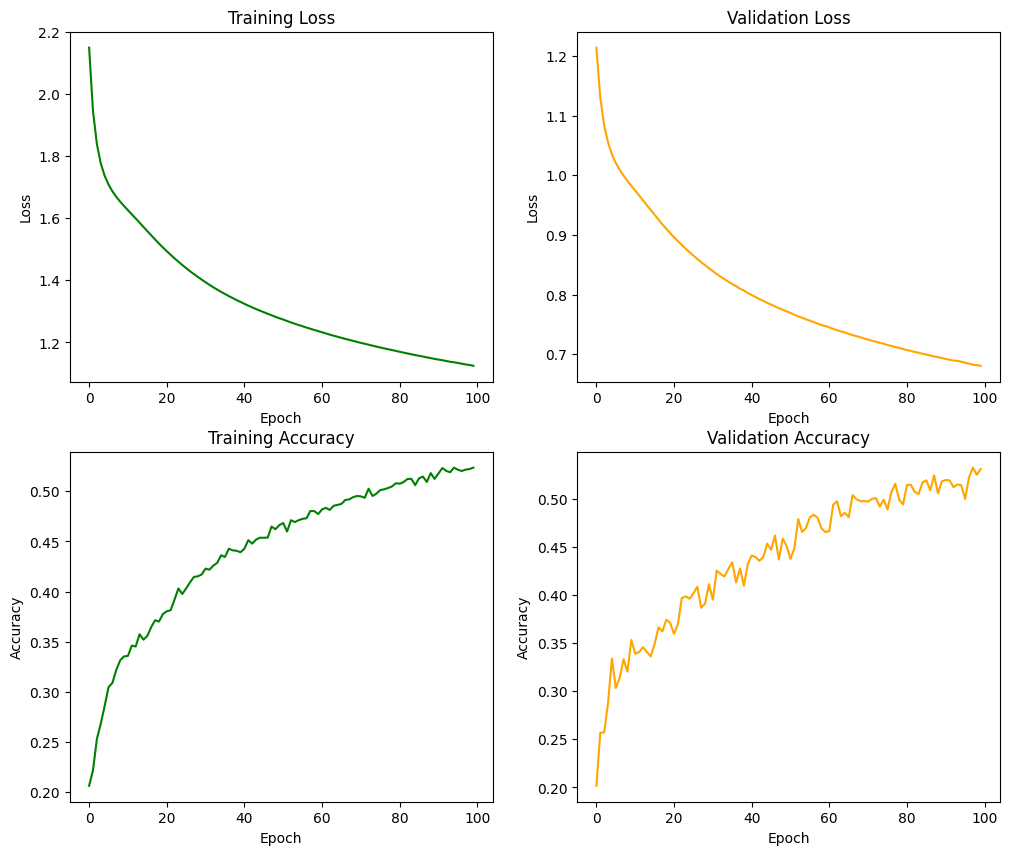

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## **7. Training 5**


In [18]:
for param in first.parameters():
    param.requires_grad = False
for param in second.parameters():
    param.requires_grad = False
for param in third.parameters():
    param.requires_grad = False

model = nn.Sequential(
    first,
    second,
    third,
    fourth,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

In [19]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(test_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 2.2842, Train_Acc: 0.1947, Validation Loss: 1.3604, Val_Acc: 0.1837
EPOCH 2/100, Train_Loss: 2.2507, Train_Acc: 0.2500, Validation Loss: 1.3409, Val_Acc: 0.2278
EPOCH 3/100, Train_Loss: 2.2140, Train_Acc: 0.2426, Validation Loss: 1.3169, Val_Acc: 0.2185
EPOCH 4/100, Train_Loss: 2.1694, Train_Acc: 0.2478, Validation Loss: 1.2880, Val_Acc: 0.2048
EPOCH 5/100, Train_Loss: 2.1166, Train_Acc: 0.2215, Validation Loss: 1.2541, Val_Acc: 0.2228
EPOCH 6/100, Train_Loss: 2.0567, Train_Acc: 0.2504, Validation Loss: 1.2172, Val_Acc: 0.2410
EPOCH 7/100, Train_Loss: 1.9937, Train_Acc: 0.2695, Validation Loss: 1.1796, Val_Acc: 0.2360
EPOCH 8/100, Train_Loss: 1.9315, Train_Acc: 0.2676, Validation Loss: 1.1438, Val_Acc: 0.2757
EPOCH 9/100, Train_Loss: 1.8735, Train_Acc: 0.3100, Validation Loss: 1.1109, Val_Acc: 0.3032
EPOCH 10/100, Train_Loss: 1.8210, Train_Acc: 0.3169, Validation Loss: 1.0817, Val_Acc: 0.3302
EPOCH 11/100, Train_Loss: 1.7749, Train_Acc: 0.3492, Validation Loss:

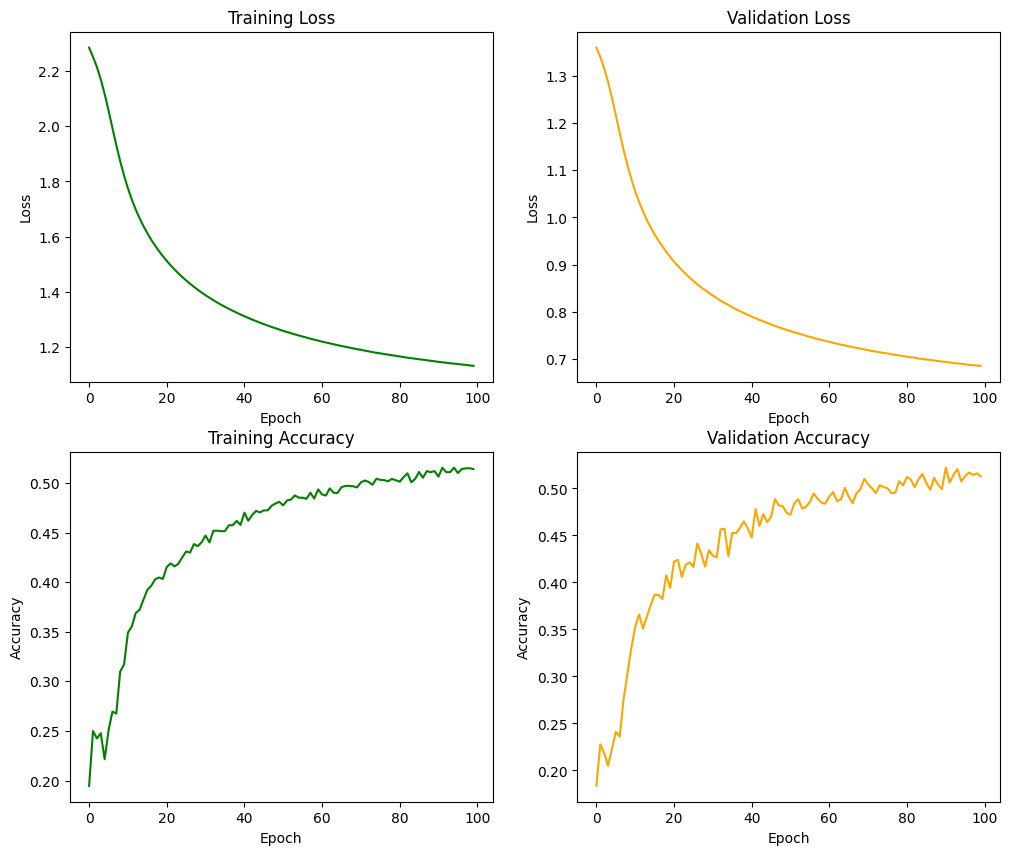

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## **8. Training 6**


In [21]:
for param in first.parameters():
    param.requires_grad = True
for param in second.parameters():
    param.requires_grad = True
for param in third.parameters():
    param.requires_grad = True

model = nn.Sequential(
    first,
    second,
    third,
    fourth,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

In [22]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(test_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 2.0725, Train_Acc: 0.2583, Validation Loss: 1.1367, Val_Acc: 0.2828
EPOCH 2/100, Train_Loss: 1.7966, Train_Acc: 0.3428, Validation Loss: 1.0379, Val_Acc: 0.3622
EPOCH 3/100, Train_Loss: 1.6744, Train_Acc: 0.3746, Validation Loss: 0.9833, Val_Acc: 0.3698
EPOCH 4/100, Train_Loss: 1.6001, Train_Acc: 0.3877, Validation Loss: 0.9471, Val_Acc: 0.3835
EPOCH 5/100, Train_Loss: 1.5467, Train_Acc: 0.3936, Validation Loss: 0.9189, Val_Acc: 0.3878
EPOCH 6/100, Train_Loss: 1.5054, Train_Acc: 0.4005, Validation Loss: 0.8969, Val_Acc: 0.3950
EPOCH 7/100, Train_Loss: 1.4719, Train_Acc: 0.4058, Validation Loss: 0.8784, Val_Acc: 0.4092
EPOCH 8/100, Train_Loss: 1.4439, Train_Acc: 0.4115, Validation Loss: 0.8629, Val_Acc: 0.4248
EPOCH 9/100, Train_Loss: 1.4194, Train_Acc: 0.4247, Validation Loss: 0.8502, Val_Acc: 0.4045
EPOCH 10/100, Train_Loss: 1.3985, Train_Acc: 0.4208, Validation Loss: 0.8384, Val_Acc: 0.4177
EPOCH 11/100, Train_Loss: 1.3800, Train_Acc: 0.4306, Validation Loss:

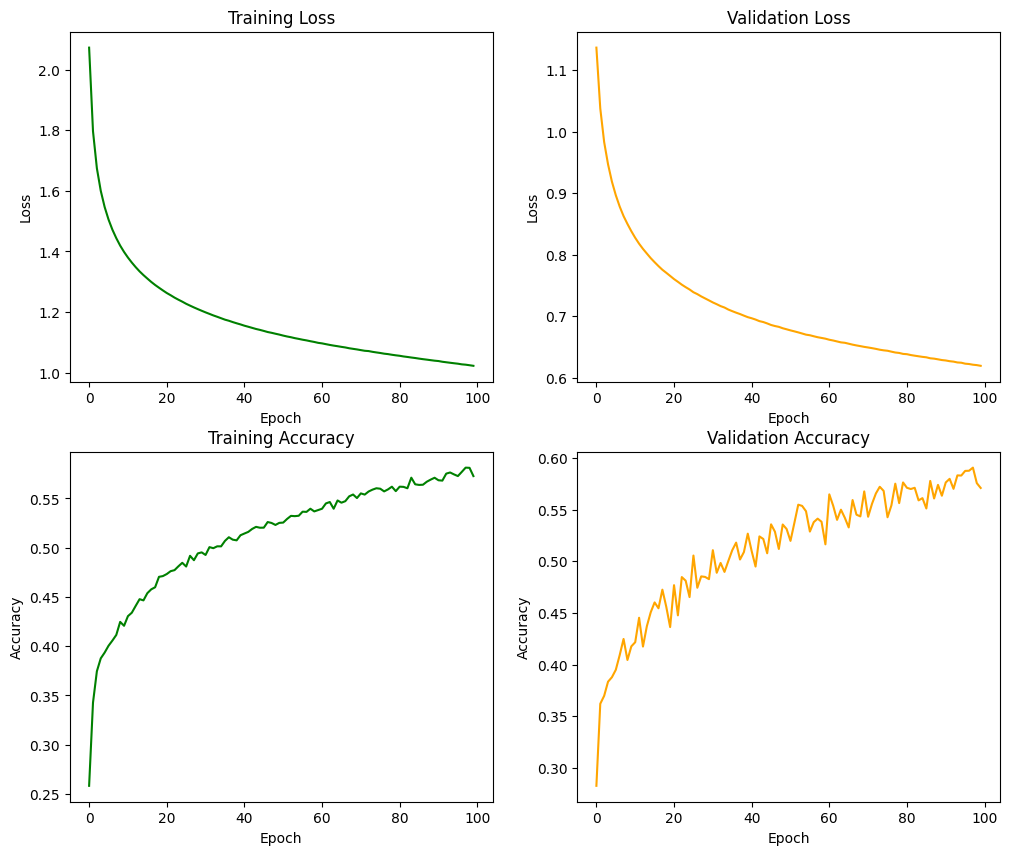

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## **9. Evaluation**

In [24]:
val_target = []
val_predict = []

model.eval()
with torch.no_grad():
    for X_val, y_val in val_loader:
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        outputs = model(X_val)

        val_predict.append(outputs.cpu())
        val_target.append(y_val.cpu())

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = (torch.argmax(val_predict, 1) == val_target).sum().item() / len(val_target)

    print('Evaluation on val set:')
    print(f'Accuracy: {val_acc}')

Evaluation on val set:
Accuracy: 0.5708333333333333


In [25]:
test_target = []
test_predict = []

model.eval()
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        outputs = model(X_test)

        test_predict.append(outputs.cpu())
        test_target.append(y_test.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = (torch.argmax(test_predict, 1) == test_target).sum().item() / len(test_target)

    print('Evaluation on test set:')
    print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.5715
